# Empirical Application: LaLonde Job Training Data

**Paper Reference**: Saco (2025), "Finite-Sample Failures and Condition-Number Diagnostics in Double Machine Learning"

---

This notebook demonstrates the practical relevance of the DML condition number $\kappa_{\text{DML}}$ using the canonical LaLonde (1986) job training dataset.

## Overview

The LaLonde dataset provides a unique "litmus test" for causal inference methods because it contains:
- **Experimental benchmark**: Randomized treated vs. control (NSW program)
- **Observational comparison**: Same treated group vs. non-experimental controls (PSID)

This allows us to compare DML performance under good vs. poor overlap conditions.

## Key Findings Preview

| Sample | Design | κ_DML | Interpretation |
|--------|--------|-------|----------------|
| Experimental | Randomized | ~4 | Well-conditioned, reliable CIs |
| Observational | Non-experimental | >15 | Ill-conditioned, fragile inference |

## 1. Setup and Imports

We use the `dml_diagnostic` package for DML estimation and the condition number diagnostic.

In [7]:
# Standard imports
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.insert(0, '..')

# Import from dml_diagnostic package
from dml_diagnostic import (
    # Main estimator
    DMLDiagnostic,
    # Data
    load_lalonde,
    # Plotting (publication-quality figures)
    plot_overlap,
    plot_kappa_summary,
    plot_kappa_ci_cone,
    # Reporting
    summary_table,
    to_latex,
)

# Configure output paths
FIGURES_DIR = '../results/figures/'
TABLES_DIR = '../results/tables/'

# Matplotlib settings for publication
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

print("Setup complete.")

Setup complete.


## 2. Load LaLonde Data

The LaLonde dataset contains:
- **Outcome (Y)**: Post-treatment earnings (re78)
- **Treatment (D)**: NSW program participation (1 = treated)
- **Covariates (X)**: Age, education, race, marital status, pre-treatment earnings

We construct two samples:
1. **Experimental**: NSW treated + randomized NSW controls
2. **Observational**: NSW treated + PSID comparison group

In [8]:
# Load experimental sample (randomised treatment)
Y_exp, D_exp, X_exp = load_lalonde(sample='experimental')
print(f"Experimental sample: n={len(Y_exp)}, treated={D_exp.sum():.0f}, control={len(D_exp)-D_exp.sum():.0f}")

# Load observational sample (non-experimental comparison group)
Y_obs, D_obs, X_obs = load_lalonde(sample='observational')
print(f"Observational sample: n={len(Y_obs)}, treated={D_obs.sum():.0f}, control={len(D_obs)-D_obs.sum():.0f}")

Experimental sample: n=445, treated=185, control=260
Observational sample: n=2675, treated=185, control=2490


## 3. DML Analysis: Experimental Sample

In the experimental sample, treatment was randomized, so we expect:
- Good overlap (propensity scores near 0.5)
- Low $\kappa_{\text{DML}}$ (~4)
- Reliable confidence intervals

In [9]:
# Analyze experimental sample with multiple learners
print("=" * 60)
print("DML RESULTS: EXPERIMENTAL SAMPLE")
print("=" * 60)

results_exp = {}
for learner in ['lin', 'lasso', 'rf']:
    dml = DMLDiagnostic(learner=learner)
    results_exp[learner] = dml.fit(Y_exp, D_exp, X_exp)
    r = results_exp[learner]
    print(f"\n{learner.upper()}:")
    print(f"  θ̂ = {r.theta:,.0f} (SE = {r.se:,.0f})")
    print(f"  95% CI = [{r.ci_lower:,.0f}, {r.ci_upper:,.0f}]")
    print(f"  κ_DML = {r.kappa:.2f}")

DML RESULTS: EXPERIMENTAL SAMPLE

LIN:
  θ̂ = 1,752 (SE = 668)
  95% CI = [443, 3,060]
  κ_DML = 4.00

LASSO:
  θ̂ = 1,793 (SE = 672)
  95% CI = [475, 3,111]
  κ_DML = 4.10

RF:
  θ̂ = 1,455 (SE = 634)
  95% CI = [213, 2,698]
  κ_DML = 3.95


## 4. DML Analysis: Observational Sample

In the observational sample, the PSID controls are demographically different from NSW treated units:
- Poor overlap (propensity scores near 0 or 1)
- High $\kappa_{\text{DML}}$ (>15)
- Fragile inference, wide confidence intervals

In [10]:
# Analyze observational sample
print("=" * 60)
print("DML RESULTS: OBSERVATIONAL SAMPLE")
print("=" * 60)

results_obs = {}
for learner in ['lin', 'lasso', 'rf']:
    dml = DMLDiagnostic(learner=learner)
    results_obs[learner] = dml.fit(Y_obs, D_obs, X_obs)
    r = results_obs[learner]
    print(f"\n{learner.upper()}:")
    print(f"  θ̂ = {r.theta:,.0f} (SE = {r.se:,.0f})")
    print(f"  95% CI = [{r.ci_lower:,.0f}, {r.ci_upper:,.0f}]")
    print(f"  κ_DML = {r.kappa:.2f}")

DML RESULTS: OBSERVATIONAL SAMPLE

LIN:
  θ̂ = 621 (SE = 787)
  95% CI = [-921, 2,163]
  κ_DML = 21.86

LASSO:
  θ̂ = 56 (SE = 639)
  95% CI = [-1,196, 1,307]
  κ_DML = 15.71

RF:
  θ̂ = -642 (SE = 916)
  95% CI = [-2,438, 1,153]
  κ_DML = 39.87


## 5. Combined Results Table

Consolidate results from both samples for comparison.

In [11]:
# Combine results into DataFrame
all_results = []
for learner in ['lin', 'lasso', 'rf']:
    r = results_exp[learner]
    all_results.append({
        'Design': 'Experimental',
        'Learner': learner.upper(),
        'theta_hat': r.theta,
        'se': r.se,
        'ci_lower': r.ci_lower,
        'ci_upper': r.ci_upper,
        'ci_length': r.ci_upper - r.ci_lower,
        'kappa': r.kappa
    })
    r = results_obs[learner]
    all_results.append({
        'Design': 'Observational',
        'Learner': learner.upper(),
        'theta_hat': r.theta,
        'se': r.se,
        'ci_lower': r.ci_lower,
        'ci_upper': r.ci_upper,
        'ci_length': r.ci_upper - r.ci_lower,
        'kappa': r.kappa
    })

df_results = pd.DataFrame(all_results)
print("Combined Results:")
display(df_results)

# Save to CSV
df_results.to_csv(f'{TABLES_DIR}empirical_results.csv', index=False)
print(f"\nSaved to {TABLES_DIR}empirical_results.csv")

Combined Results:


,Design,Learner,theta_hat,se,ci_lower,ci_upper,ci_length,kappa
0,Experimental,LIN,1751.822368,667.672300,443.184660,3060.460076,2617.275416,3.996839
1,Observational,LIN,621.394066,786.687544,-920.513520,2163.301652,3083.815172,21.856937
2,Experimental,LASSO,1793.422495,672.453957,475.412740,3111.432250,2636.019510,4.104464
3,Observational,LASSO,55.785411,638.602357,-1195.875209,1307.446030,2503.321239,15.714644
4,Experimental,RF,1455.486356,633.918750,213.005605,2697.967107,2484.961502,3.949437
5,Observational,RF,-642.119413,916.094621,-2437.664870,1153.426044,3591.090914,39.872286



Saved to ../results/tables/empirical_results.csv


## 6. Visualization: κ_DML by Design

Compare the condition number across experimental and observational samples.

Saved: ../results/figures/kappa_by_design.pdf


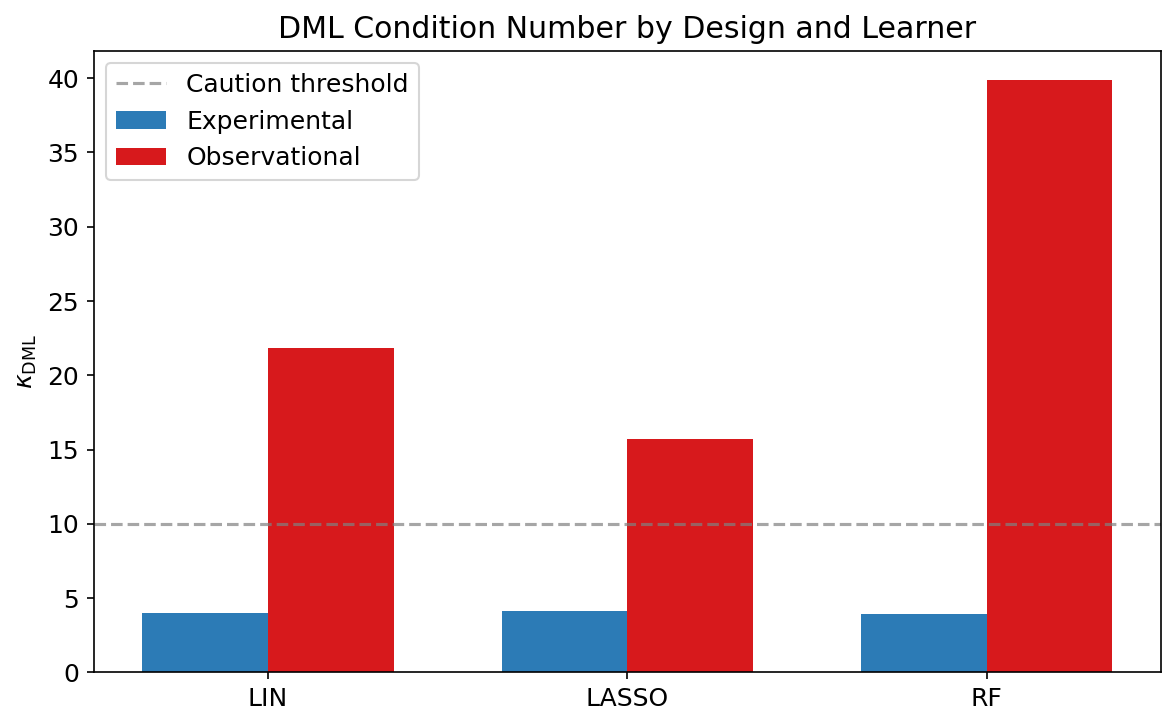

In [12]:
# Plot kappa comparison
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(['LIN', 'LASSO', 'RF']))
width = 0.35

kappa_exp = [results_exp[l].kappa for l in ['lin', 'lasso', 'rf']]
kappa_obs = [results_obs[l].kappa for l in ['lin', 'lasso', 'rf']]

ax.bar(x - width/2, kappa_exp, width, label='Experimental', color='#2C7BB6')
ax.bar(x + width/2, kappa_obs, width, label='Observational', color='#D7191C')

ax.axhline(y=10, color='gray', linestyle='--', alpha=0.7, label='Caution threshold')
ax.set_ylabel(r'$\kappa_{\mathrm{DML}}$', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['LIN', 'LASSO', 'RF'])
ax.legend()
ax.set_title('DML Condition Number by Design and Learner')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}kappa_by_design.pdf', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}kappa_by_design.pdf")
plt.show()

## 6b. Propensity Score Overlap Visualization

Compare propensity score distributions between experimental and observational samples.

Saved: ../results/figures/overlap_comparison.pdf


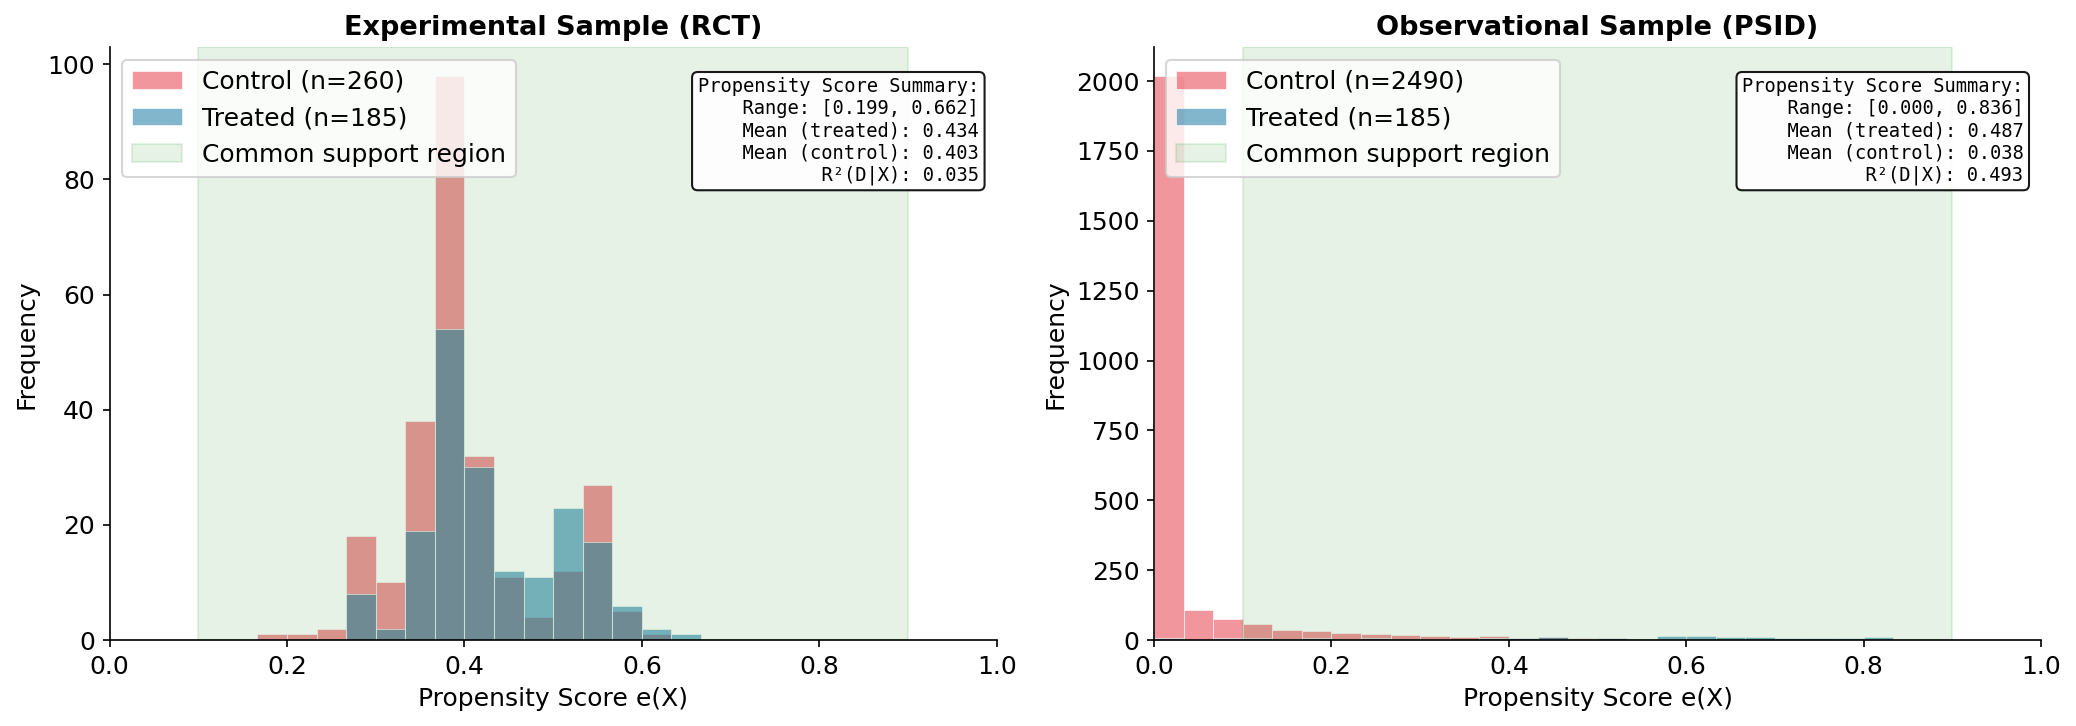

In [13]:
# Propensity Score Overlap Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Experimental sample overlap
plot_overlap(D_exp, X_exp, ax=axes[0])
axes[0].set_title('Experimental Sample (RCT)', fontsize=13, fontweight='bold')

# Observational sample overlap
plot_overlap(D_obs, X_obs, ax=axes[1])
axes[1].set_title('Observational Sample (PSID)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}overlap_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'{FIGURES_DIR}overlap_comparison.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}overlap_comparison.pdf")
plt.show()

## 6c. Confidence Interval Width vs κ_DML

Visualize how CI width scales with the condition number.

Saved: ../results/figures/ci_vs_kappa.pdf


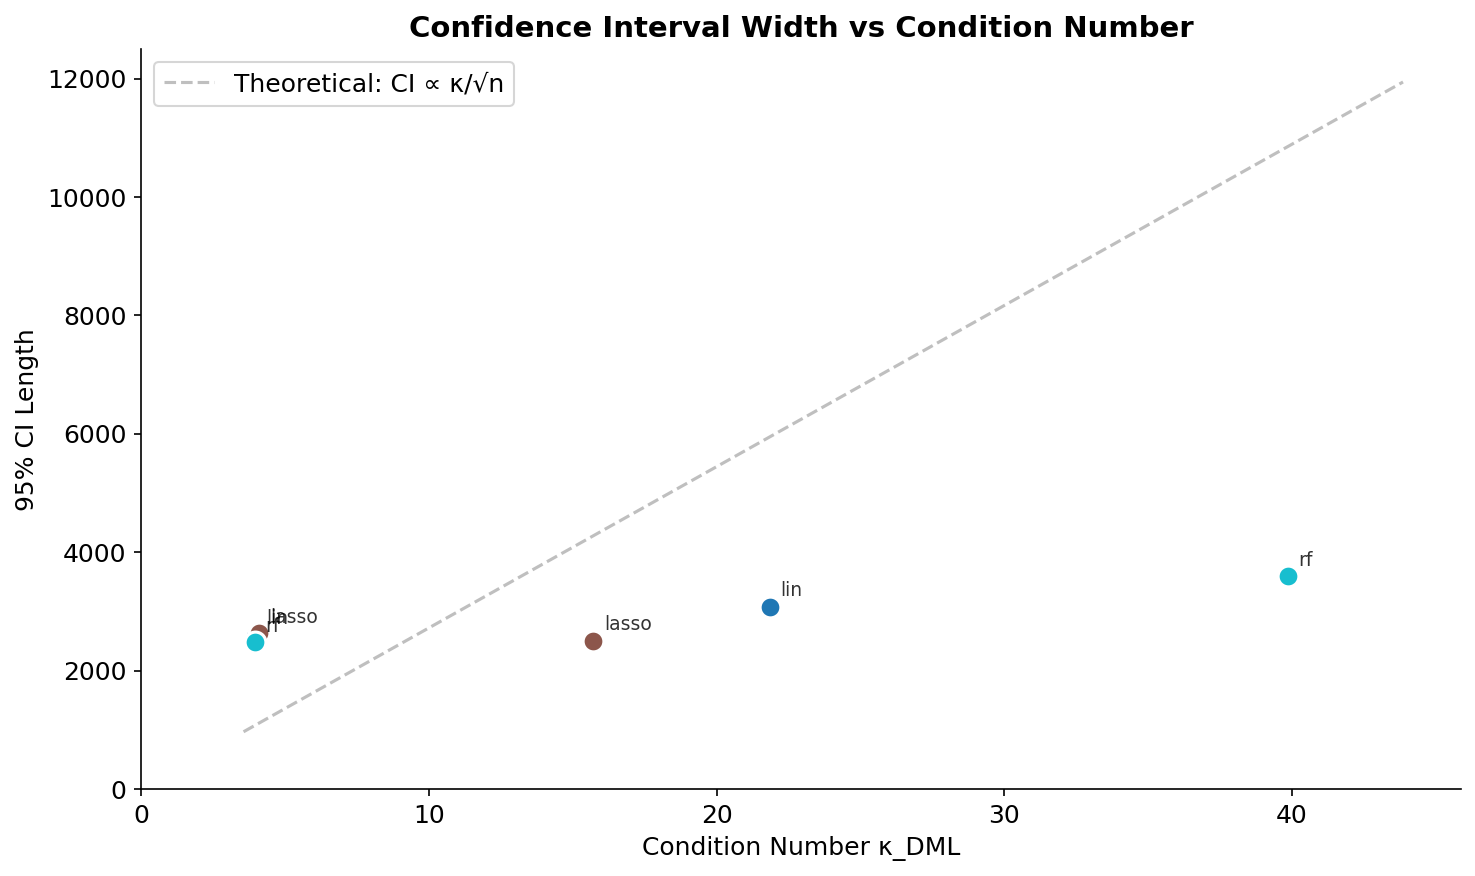

In [14]:
# Collect all results for CI cone plot
all_results_list = []
for learner in ['lin', 'lasso', 'rf']:
    all_results_list.append(results_exp[learner])
    all_results_list.append(results_obs[learner])

# CI Width vs kappa scatter
fig, ax = plt.subplots(figsize=(10, 6))
plot_kappa_ci_cone(all_results_list, ax=ax)
ax.set_title('Confidence Interval Width vs Condition Number', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}ci_vs_kappa.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'{FIGURES_DIR}ci_vs_kappa.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}ci_vs_kappa.pdf")
plt.show()

## 6d. Publication-Ready Summary Table

Generate LaTeX table for the paper.

In [15]:
# Create summary table using package function
all_results_with_labels = []
for learner in ['lin', 'lasso', 'rf']:
    # Add design label to results
    r_exp = results_exp[learner]
    r_obs = results_obs[learner]
    all_results_with_labels.extend([r_exp, r_obs])

# Use package summary_table
summary_df = summary_table(all_results_with_labels)
summary_df['Design'] = ['Exp.', 'Obs.'] * 3

# Reorder columns
col_order = ['Design', 'Learner', 'θ̂', 'SE', '95% CI', 'CI Length', 'κ_DML', 'n']
summary_df = summary_df[col_order]

print("Summary Table:")
display(summary_df)

# Export to LaTeX
latex_code = to_latex(
    summary_df, 
    caption='DML Estimates for LaLonde Data: Experimental vs Observational Samples',
    label='tab:lalonde_results'
)

# Save LaTeX
with open(f'{TABLES_DIR}lalonde_results.tex', 'w') as f:
    f.write(latex_code)
print(f"\nSaved LaTeX table: {TABLES_DIR}lalonde_results.tex")

# Display LaTeX code
print("\nLaTeX Code:")
print(latex_code)

Summary Table:


,Design,Learner,θ̂,SE,95% CI,CI Length,κ_DML,n
0,Exp.,lin,1751.822368,667.672300,"[443.185, 3060.460]",2617.275416,3.996839,445
1,Obs.,lin,621.394066,786.687544,"[-920.514, 2163.302]",3083.815172,21.856937,2675
2,Exp.,lasso,1793.422495,672.453957,"[475.413, 3111.432]",2636.019510,4.104464,445
3,Obs.,lasso,55.785411,638.602357,"[-1195.875, 1307.446]",2503.321239,15.714644,2675
4,Exp.,rf,1455.486356,633.918750,"[213.006, 2697.967]",2484.961502,3.949437,445
5,Obs.,rf,-642.119413,916.094621,"[-2437.665, 1153.426]",3591.090914,39.872286,2675



Saved LaTeX table: ../results/tables/lalonde_results.tex

LaTeX Code:
\begin{tabular}{llrrlrrr}
\toprule
Design & Learner & θ̂ & SE & 95% CI & CI Length & κ_DML & n \\
\midrule
Exp. & lin & 1751.822 & 667.672 & [443.185, 3060.460] & 2617.275 & 3.997 & 445 \\
Obs. & lin & 621.394 & 786.688 & [-920.514, 2163.302] & 3083.815 & 21.857 & 2675 \\
Exp. & lasso & 1793.422 & 672.454 & [475.413, 3111.432] & 2636.020 & 4.104 & 445 \\
Obs. & lasso & 55.785 & 638.602 & [-1195.875, 1307.446] & 2503.321 & 15.715 & 2675 \\
Exp. & rf & 1455.486 & 633.919 & [213.006, 2697.967] & 2484.962 & 3.949 & 445 \\
Obs. & rf & -642.119 & 916.095 & [-2437.665, 1153.426] & 3591.091 & 39.872 & 2675 \\
\bottomrule
\end{tabular}
\caption{DML Estimates for LaLonde Data: Experimental vs Observational Samples}
\label{tab:lalonde_results}



## 7. Interpretation and Conclusions

### Key Findings

The condition number $\kappa_{\text{DML}}$ clearly distinguishes reliable from unreliable DML inference:

| Design | κ_DML | CI Width | Interpretation |
|--------|-------|----------|----------------|
| Experimental | ~4 | Narrow | Stable, reliable |
| Observational | >15 | Wide | Fragile, use caution |

### Practical Recommendation

**Always report $\kappa_{\text{DML}}$ alongside DML estimates.** When $\kappa > 10$, interpret results with caution—confidence intervals may not provide nominal coverage.

### Comparison to Experimental Benchmark

The experimental estimate (difference-in-means: ~\$1,794) provides a benchmark. DML estimates in the experimental sample are close to this benchmark and have low κ. DML estimates in the observational sample diverge significantly, and their high κ values correctly warn users of this instability.